# Prelude
Hehe this was a fun activity actually.

# Acknowledgements
I'd like to thank my instructors, Sir Rene Principe Jr. and Sir Kenneth Leo, for guiding me throughout the activity. I would also like to thank my professor, Ma'am Jing, for guiding me in my coding while my classmates and I worked in R202. I would also like to acknowledge my classmates: Abdel, Johnenn, Jonabel, Richmond, Lovely, Hans, Genesis, Jeruine, Rusher, and Ron for helping me complete this activity.

# Code starts Here

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import statistics as st

image_repository = "./image repository/"

# initializing this so I have a placeholder
image = 0

> #### ${\tt thresholding(image, stdev_mult):}$
> 1. Accepts a grayscale image
> 2. Gets the median and standard deviation of the image.
> 3. Binarizes the image by zeroing out the values that are in the range [median - ${\tt stdev\_mult}\times$(stdev), median + ${\tt stdev\_mult}\times$(stdev)] and setting the other values to $1$.
> 4. Returns the binarized image.<br>
> $~$

In [58]:
def thresholding(image, stdev_mult):


    # I'll automate the thresholding. Since we know that the highest peak in the histogram represents the image's background, 
    # my left and right borders will be np.median(image) -+ stdev_mult*stdev respectively.
    peak_ = np.median(image.flatten())
    stdev_ = np.std(image.flatten())

    # Now setting up the borders
    left_border = int(np.floor(peak_ - stdev_mult*stdev_))
    right_border = int(np.ceil(peak_ + stdev_mult*stdev_))

    # Converting to binary through. The values to the left of the left border and to the right of the right boarder are set to 1.
    T, thresholded = cv2.threshold(image, left_border, right_border, cv2.THRESH_BINARY_INV)

    return thresholded


> #### ${\tt convert\_NCC(image):}$
> Converts an image into its normalized chromaticity coordinates and returns the converted image.<br>
> $~$

In [59]:
def convert_NCC(image):

    image_rgb = np.zeros(image.shape)

    image_R = image[...,0]
    image_G = image[...,1]
    image_B = image[...,2]

    image_R = (image_R - np.min(image_R))/(np.max(image_R) - np.min(image_R))
    image_G = (image_G - np.min(image_G))/(np.max(image_G) - np.min(image_G))
    image_B = (image_B - np.min(image_B))/(np.max(image_B) - np.min(image_B))

    # Adding 1e-8 so there's no 1/0
    I = image_R + image_G + image_B + 1e-8

    image_r = image_R/I
    image_g = image_G/I
    image_b = image_B/I

    image_rgb[...,0] = image_r
    image_rgb[...,1] = image_g
    image_rgb[...,2] = image_b

    return image_rgb

> #### ${\tt non\_parametric(image, x, y, bins = 32, ROI\_size = 32):}$
> 1. ${\tt x}$ and ${\tt y}$ are the coordinates (in pixels) of the upper left corner of the ROI. ${\tt ROI\_size}$ serves as the length and width of the ROI in pixels.
> 2. Converts the image and the ROI to its NCC and builds the 2D histogram with ${\tt bins}$ as the number of bins, $g$ on the $y$-axis, and $r$ on the $x$-axis.
> 3. Applies histogram backprojection on the image.  The backprojected image is the segmented image using non-parametric segmentation.
> 4. Returns the backprojected image.<br>
> $~$

In [60]:
def non_parametric(image, x, y, bins = 32, ROI_size = 32):
    
    # Converting to NCC
    image_NCC = convert_NCC(image)
    ROI = image_NCC[y:y+ROI_size, x:x+ROI_size]
    ROI = np.float32(ROI)
    plt.imshow(ROI)
    plt.show()
    # Getting 2D histogram
    ROI_hist = cv2.calcHist([ROI], [1, 0], None, [bins, bins], [0, 1, 0, 1])
    ROI_hist = ROI_hist/(np.max(ROI_hist) + 0.0001)
   

    # Applying Backprojection
    image_r = (bins*image_NCC[..., 0]).flatten()
    image_g = (bins*image_NCC[..., 1]).flatten()

    image_r = np.floor(image_r).astype(int)
    image_g = np.floor(image_g).astype(int)

    backprojected = np.zeros(image.shape)
    backprojected = ROI_hist[image_g, image_r]

    backprojected = np.reshape(backprojected, (image.shape[0], image.shape[1]))

    return backprojected

> #### ${\tt morphing\_time(filename, commands):}$
> 1. opens the image with the stated ${\tt filename}$.
> 2. Loops through a list of ${\tt commands}$ which contains the morphological operations along with their parameters.
> 3. Displays the original image and the final processed image.
> $~$

In [61]:
def morphing_time(filename, commands):
    image = cv2.imread(image_repository + filename)
    original_image = image.copy()
    temp_image = image.copy()
    for i in range(len(commands)):
        process = commands[i][0].lower()

        match process:
            case 'grayscale':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            case 'thresholding':
                image = thresholding(image, commands[i][1])
            case 'dilation':
                image = cv2.erode(image, commands[i][1], iterations = commands[i][2])
            case 'erosion':
                image = cv2.erode(image, commands[i][1], commands[i][2])
            case 'opening':
                image = cv2.morphologyEx(image, cv2.MORPH_OPEN, commands[i][1])
            case 'closing':
                image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, commands[i][1])
            case 'median_blur':
                image = cv2.medianBlur(image, commands[i][1])
            case 'segment_nonpara':
                image = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                image = non_parametric(image, commands[i][1], commands[i][2], bins = commands[i][3], ROI_size = commands[i][4])
            case 'simple_binarize':
                image[image != 0] = 1
            case other:
                print(commands[i][0] + " did nothing lol.")

        # Only used this part to produce the pictures in my report.
        # fig, ax = plt.subplots(1,2, figsize = (7,3))
        # ax[0].imshow(temp_image, cmap = "gray")
        # ax[0].set_title("Before processing")

        # ax[1].imshow(image, cmap = "gray")
        # ax[1].set_title("After processing: " + str(process))

        # plt.tight_layout()
        # plt.show()

        # temp_image = image.copy()

    fig, ax = plt.subplots(1,2, figsize = (12,8))
    ax[0].imshow(original_image)
    ax[0].set_title(filename)

    ax[1].imshow(image, cmap = "gray")
    ax[1].set_title("Processed Image")

    plt.tight_layout()
    plt.show()


> #### ${\tt square(w, h, xshift = 0, yshift = 0, invert = False):}$
> 1. Creates a square with a width of ${\tt w}$ and a height of ${\tt h}$ at the center of a $20\times 20$ matrix.
> 2. If ${\tt xshift}$ and/or ${\tt yshift}$ are given values, then the center of the square are shifted accordingly.
> 3. If ${\tt invert}$ is set to ${\tt True}$, then the square will be made of $0$s while the other pixels in the matrix are set to $1$s.
> $~$

In [62]:
def square(w, h, xshift = 0, yshift = 0, invert = False):
    x = np.arange(-10, 11, 1)
    y = x
    X,Y = np.meshgrid(x,y)
    A = np.ones((21,21))
    A[X > w/2 + xshift] = 0
    A[X < -w/2 + xshift] = 0
    A[Y > h/2 + yshift] = 0
    A[Y < -h/2 + yshift] = 0

    if invert == True:
        A = A - 1
        A = A*(-1)
    
    return A

> #### Below are the functions that I made for Activity 6.1
> The following functions creates the shapes and the structuring element with the specified dimensions based on the laboratory manual.
> $~$

In [63]:
def make_5by5():
    return square(5,5)

def make_hollow10by10():
    output = square(10,10) - square(6,6)
    output[output < 0] = 0
    return output

def make_cross():
    output = square(5,1)
    output += square(1,5)
    output[output > 1] = 1
    return output

def make_dumbell():
    output = square(3,1)
    output += square(5,5, xshift = 4)
    output += square(5,5, xshift = -4)
    return output

def kernel_a():
    return np.ones([2,2])
def kernel_b():
    return cv2.getStructuringElement(cv2.MORPH_RECT,(2,1))
def kernel_c():
    return cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))


>#### ${\tt Erosion():}$
> This is the function that I used to erode each shape with each structuring element. And I displayed all of the outputs. <br>


In [64]:
# Now solving for everything and putting them all in the same plot

# Starting with erosion
def Erosion():
    square_erode_a= cv2.erode(make_5by5(), kernel_a(), anchor =(0,0))
    square_erode_b= cv2.erode(make_5by5(), kernel_b(), anchor =(0,0))
    square_erode_c= cv2.erode(make_5by5(), kernel_c(), anchor =(2,2))

    hollow_erode_a= cv2.erode(make_hollow10by10(), kernel_a(), anchor =(0,0))
    hollow_erode_b= cv2.erode(make_hollow10by10(), kernel_b(), anchor =(0,0))
    hollow_erode_c= cv2.erode(make_hollow10by10(), kernel_c(), anchor =(2,2))

    cross_erode_a= cv2.erode(make_cross(), kernel_a(), anchor =(0,0))
    cross_erode_b= cv2.erode(make_cross(), kernel_b(), anchor =(0,0))
    cross_erode_c= cv2.erode(make_cross(), kernel_c(), anchor =(2,2))

    dumbell_erode_a= cv2.erode(make_dumbell(), kernel_a(), anchor =(0,0))
    dumbell_erode_b= cv2.erode(make_dumbell(), kernel_b(), anchor =(0,0))
    dumbell_erode_c= cv2.erode(make_dumbell(), kernel_c(), anchor =(2,2))

    # Kernel picture
    kernel_a_picture = square(0,0)
    kernel_a_picture[10:12, 10:12] += kernel_a()

    kernel_b_picture = square(0,0)
    kernel_b_picture[10, 10:12] += 1

    kernel_c_picture = square(5,5)
    kernel_c_picture[10, 10] += 1


    fig, ax = plt.subplots(4,5, figsize = (25, 20))
    ax[0,0].axis('off')

    # First Row
    ax[0,1].imshow(make_5by5(), cmap = "gray")
    ax[0,2].imshow(make_hollow10by10(), cmap = "gray")
    ax[0,3].imshow(make_cross(), cmap = "gray")
    ax[0,4].imshow(make_dumbell(), cmap = "gray")

    # Second Row
    ax[1,0].imshow(kernel_a_picture, cmap = "gray")
    ax[1,1].imshow(square_erode_a, cmap = "gray")
    ax[1,2].imshow(hollow_erode_a, cmap = "gray")
    ax[1,3].imshow(cross_erode_a, cmap = "gray")
    ax[1,4].imshow(dumbell_erode_a, cmap = "gray")

    # Third Row
    ax[2,0].imshow(kernel_b_picture, cmap = "gray")
    ax[2,1].imshow(square_erode_b, cmap = "gray")
    ax[2,2].imshow(hollow_erode_b, cmap = "gray")
    ax[2,3].imshow(cross_erode_b, cmap = "gray")
    ax[2,4].imshow(dumbell_erode_b, cmap = "gray")

    # Fourth Row
    ax[3,0].imshow(kernel_c_picture, cmap = "gray")
    ax[3,1].imshow(square_erode_c, cmap = "gray")
    ax[3,2].imshow(hollow_erode_c, cmap = "gray")
    ax[3,3].imshow(cross_erode_c, cmap = "gray")
    ax[3,4].imshow(dumbell_erode_c, cmap = "gray")
    plt.tight_layout()
    plt.show()

>#### ${\tt Dilation():}$
> This is the function that I used to dilate each shape with each structuring element. And I displayed all of the outputs. <br>

In [65]:
# Now with dilation
def Dilation():

    square_dilate_a= cv2.dilate(make_5by5(), kernel_a(), anchor =(0,0))
    square_dilate_b= cv2.dilate(make_5by5(), kernel_b(), anchor =(0,0))
    square_dilate_c= cv2.dilate(make_5by5(), kernel_c(), anchor =(2,2))

    hollow_dilate_a= cv2.dilate(make_hollow10by10(), kernel_a(), anchor =(0,0))
    hollow_dilate_b= cv2.dilate(make_hollow10by10(), kernel_b(), anchor =(0,0))
    hollow_dilate_c= cv2.dilate(make_hollow10by10(), kernel_c(), anchor =(2,2))

    cross_dilate_a= cv2.dilate(make_cross(), kernel_a(), anchor =(0,0))
    cross_dilate_b= cv2.dilate(make_cross(), kernel_b(), anchor =(0,0))
    cross_dilate_c= cv2.dilate(make_cross(), kernel_c(), anchor =(2,2))

    dumbell_dilate_a= cv2.dilate(make_dumbell(), kernel_a(), anchor =(0,0))
    dumbell_dilate_b= cv2.dilate(make_dumbell(), kernel_b(), anchor =(0,0))
    dumbell_dilate_c= cv2.dilate(make_dumbell(), kernel_c(), anchor =(2,2))

    # Kernel picture
    kernel_a_picture = square(0,0)
    kernel_a_picture[10:12, 10:12] += kernel_a()

    kernel_b_picture = square(0,0)
    kernel_b_picture[10, 10:12] += 1

    kernel_c_picture = square(5,5)
    kernel_c_picture[10, 10] += 1


    fig, ax = plt.subplots(4,5, figsize = (30, 25))
    ax[0,0].axis('off')

    # First Row
    ax[0,1].imshow(make_5by5(), cmap = "gray")
    ax[0,2].imshow(make_hollow10by10(), cmap = "gray")
    ax[0,3].imshow(make_cross(), cmap = "gray")
    ax[0,4].imshow(make_dumbell(), cmap = "gray")

    # Second Row
    ax[1,0].imshow(kernel_a_picture, cmap = "gray")
    ax[1,1].imshow(square_dilate_a, cmap = "gray")
    ax[1,2].imshow(hollow_dilate_a, cmap = "gray")
    ax[1,3].imshow(cross_dilate_a, cmap = "gray")
    ax[1,4].imshow(dumbell_dilate_a, cmap = "gray")

    # Third Row
    ax[2,0].imshow(kernel_b_picture, cmap = "gray")
    ax[2,1].imshow(square_dilate_b, cmap = "gray")
    ax[2,2].imshow(hollow_dilate_b, cmap = "gray")
    ax[2,3].imshow(cross_dilate_b, cmap = "gray")
    ax[2,4].imshow(dumbell_dilate_b, cmap = "gray")

    # Fourth Row
    ax[3,0].imshow(kernel_c_picture, cmap = "gray")
    ax[3,1].imshow(square_dilate_c, cmap = "gray")
    ax[3,2].imshow(hollow_dilate_c, cmap = "gray")
    ax[3,3].imshow(cross_dilate_c, cmap = "gray")
    ax[3,4].imshow(dumbell_dilate_c, cmap = "gray")
    plt.tight_layout()
    plt.show()

# Outputs

### For checking my hand drawn outputs

#### ${\tt Erosion}$
*I can't seem to place it in the figure title, so I'll place it here in the mardown box.*

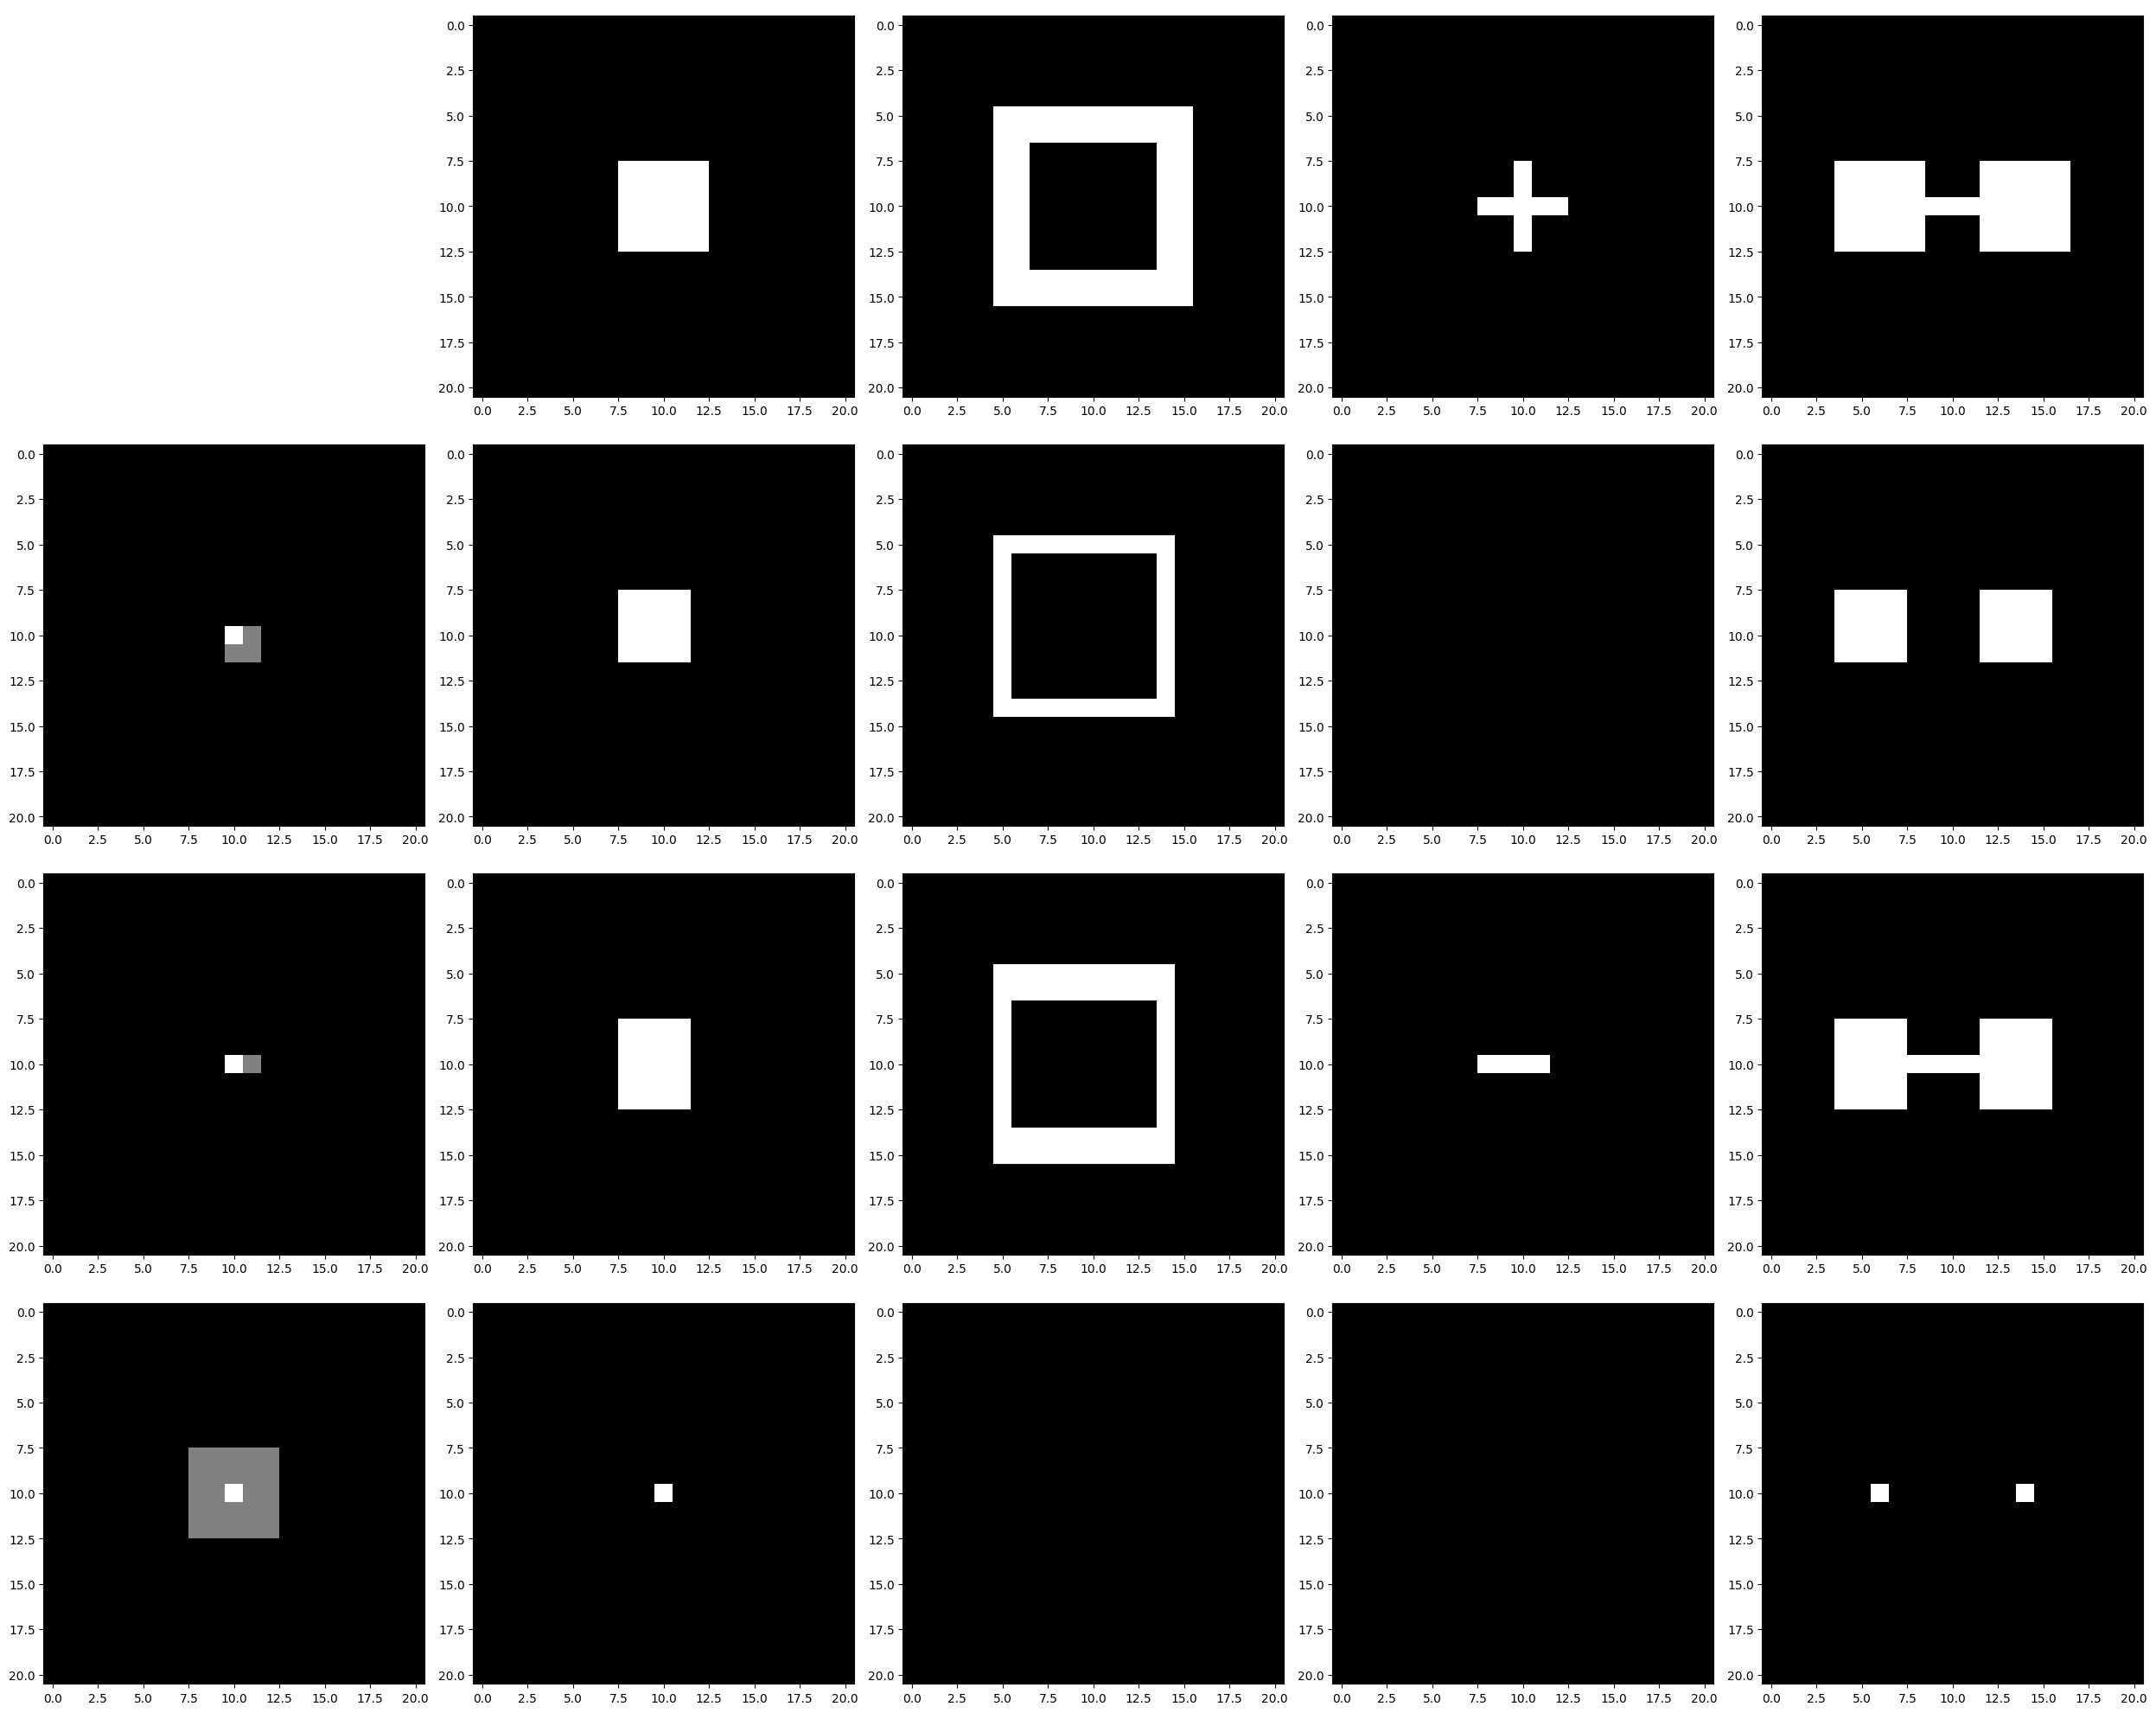

In [66]:
Erosion()

#### ${\tt Dilation}$
*I can't seem to place it in the figure title, so I'll place it here in the mardown box.*

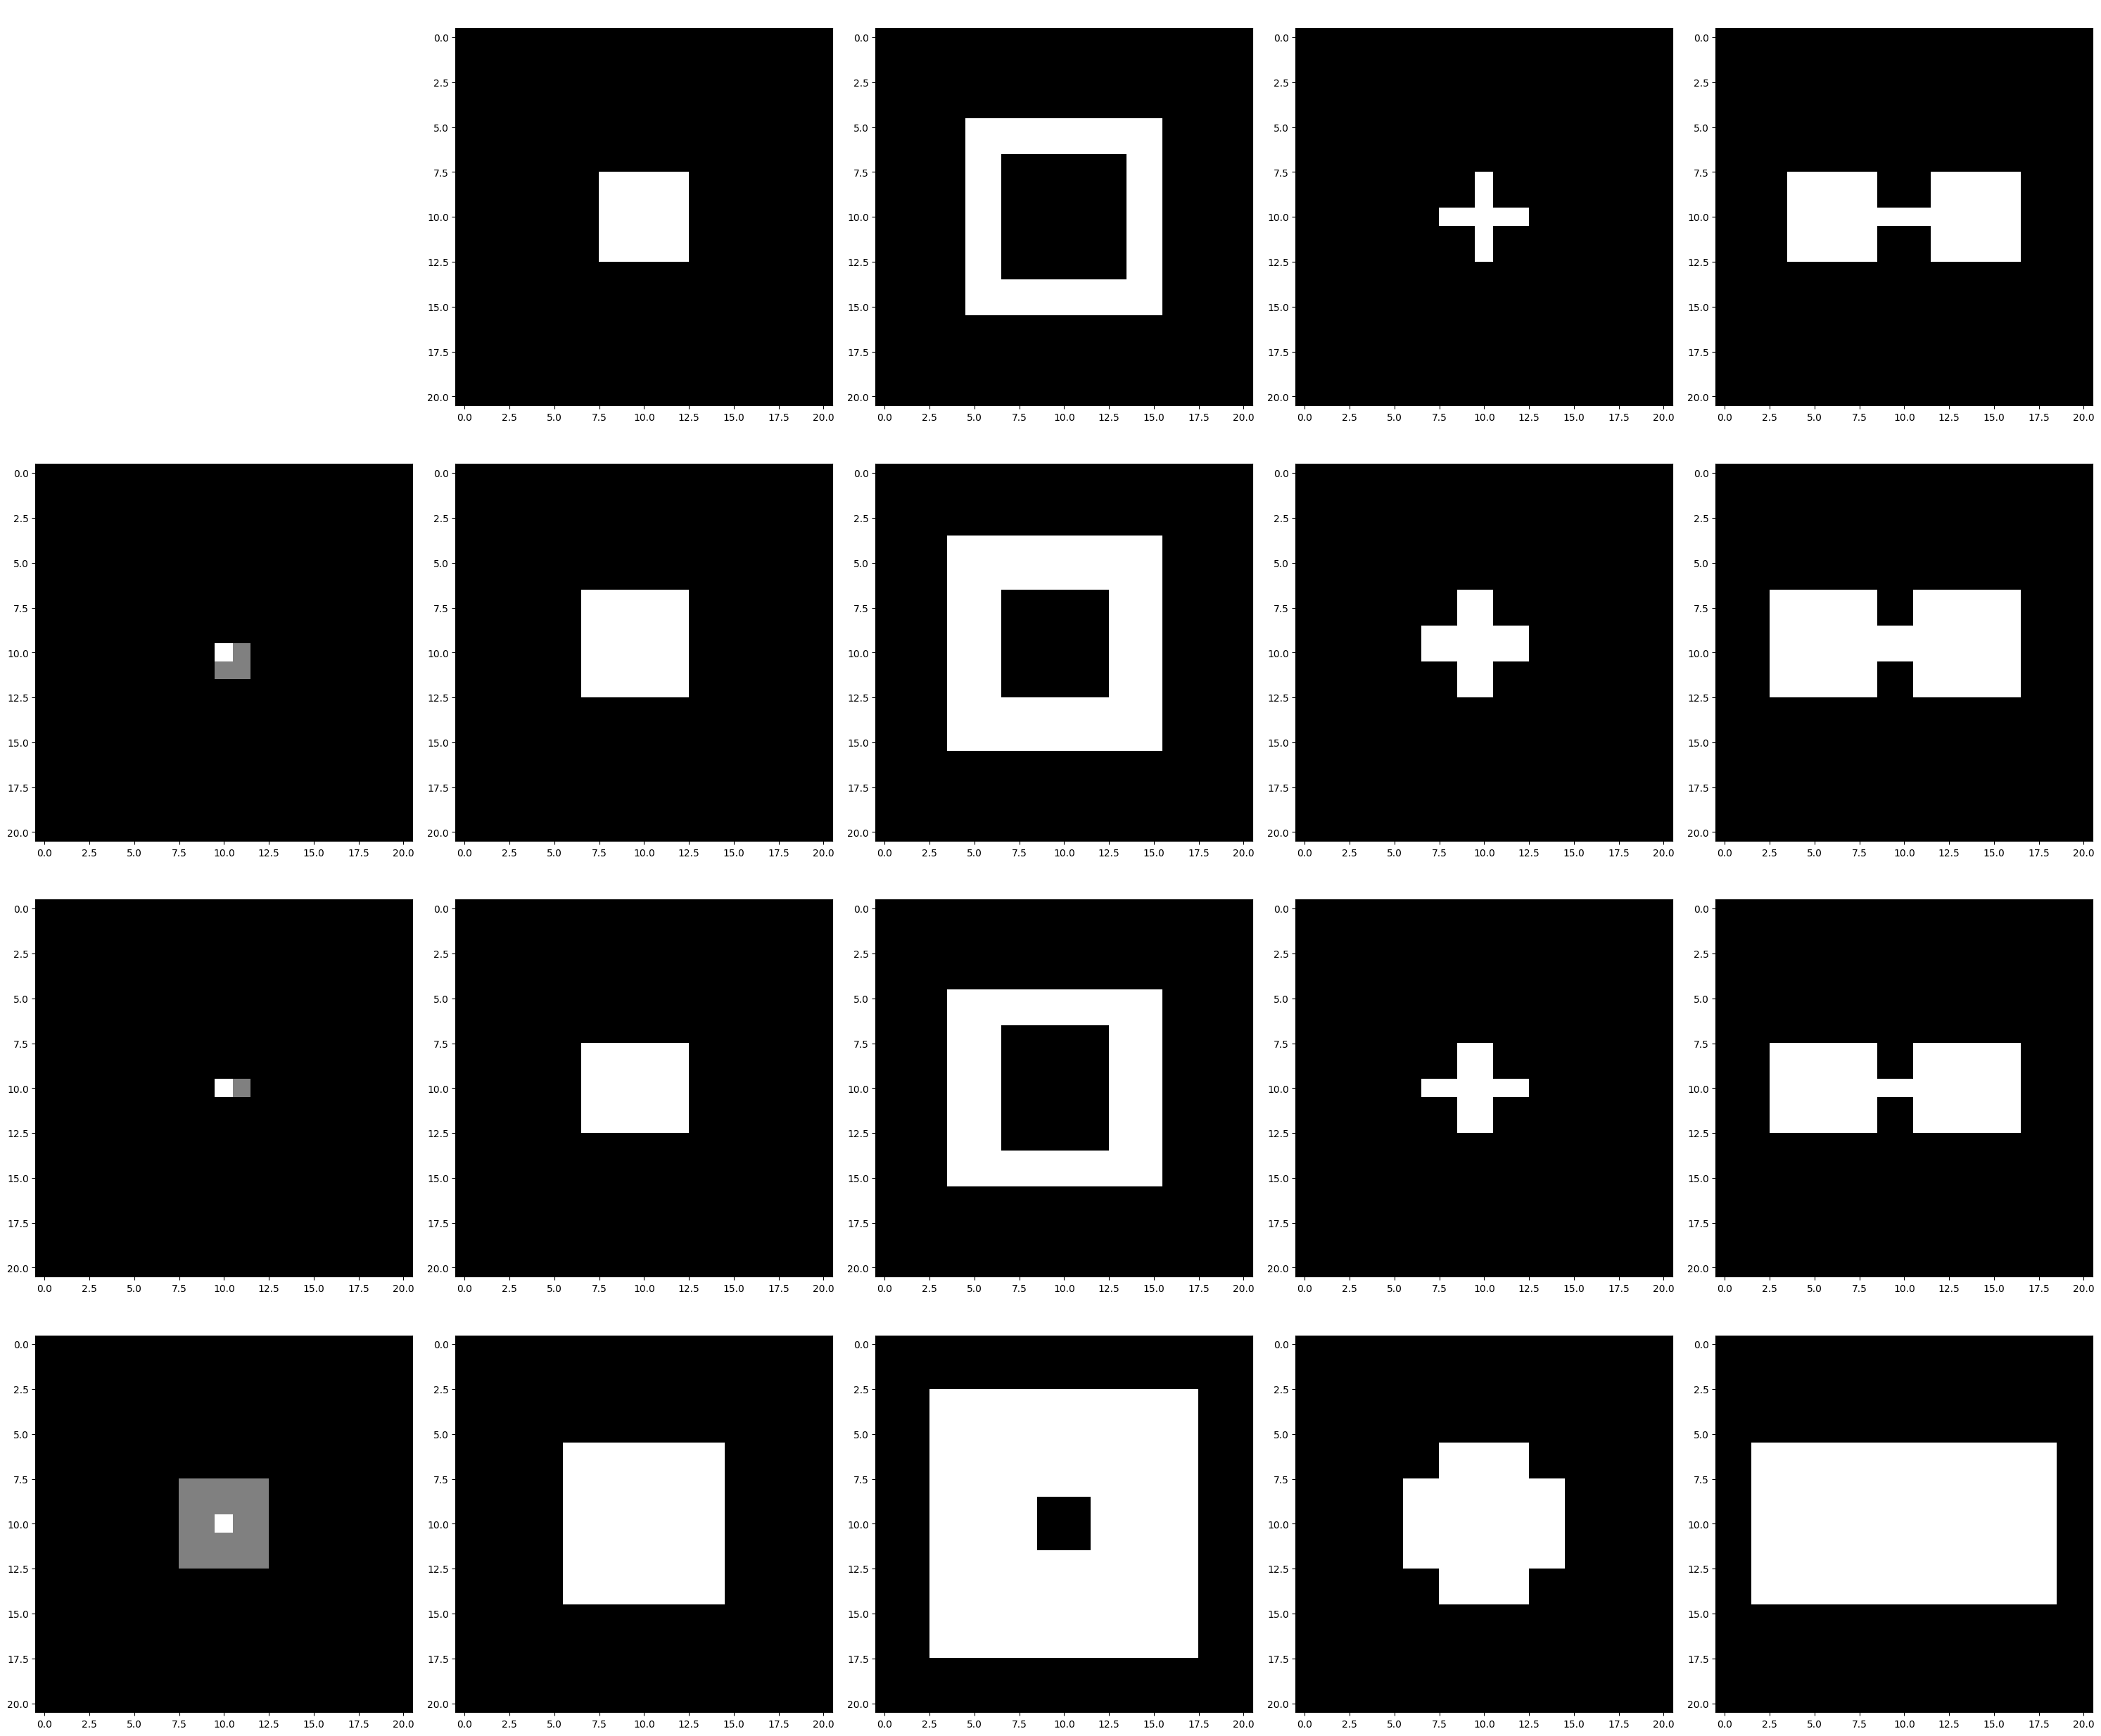

In [67]:
Dilation()

>### For the malaria data processing
>
>In this part of the activity, I applied different morphological operations on the malaria image. The operations that I did below is my best attempt at detecting the malaria cells. 

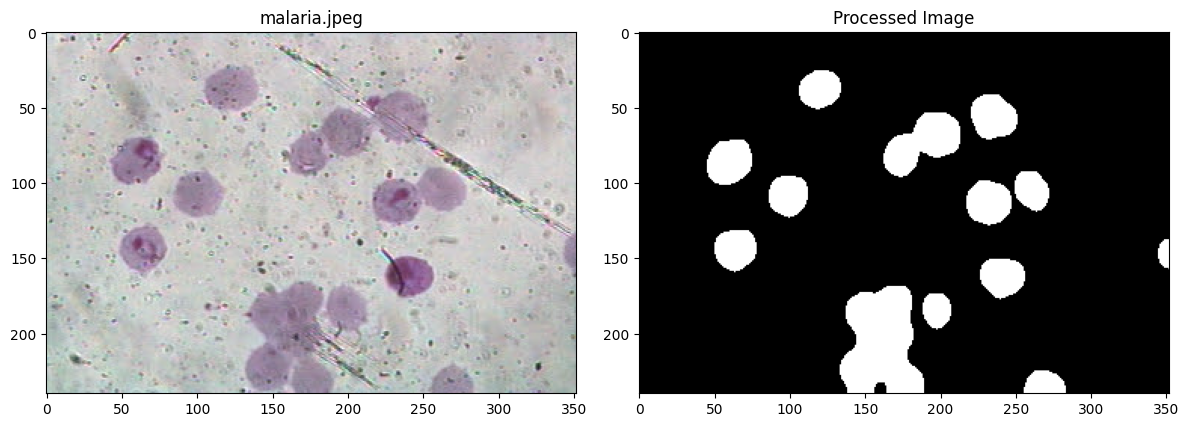

In [68]:
commands = [
            ['grayscale'],
            ['median_blur', 5],
            ['thresholding', 1.65],
            ["opening", cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,10))],
            ["closing", cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,13))],
            ["opening", cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,20))],
]
morphing_time("malaria.jpeg", commands)